In [1]:
import operator
from typing import Annotated, TypedDict
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph

import models
import diagnose_prompt
import care_plan_prompt
import test_reports
import extract_pdf

# Define the overall state
class OverallState(TypedDict):
    pdf_path: str
    report: str
    diagnosis: str
    care_plan: str
    provider_message: str

# Define individual node states
class ExtractPDFState(TypedDict):
    pdf_path: str

class DiagnosisState(TypedDict):
    report: str
    context: str

class CarePlanState(TypedDict):
    report: str
    context: str

class ProviderAssistState(TypedDict):
    diagnosis: str
    care_plan: str

# Node functions
def extract_pdf_report(state: ExtractPDFState):
    report = extract_pdf.sync_extract_report_from_pdf(state["pdf_path"])
    return {"report": report}

def summary_diagnosis(state: DiagnosisState):
    with open('ajnr.md', 'r') as out_file:
        context = out_file.read()
    diagnosis = models.call_openai(diagnose_prompt.DIAGNOSE_PROMPT.format(context=context, report=state["report"])).choices[0].message.content
    return {"diagnosis": diagnosis}

def generate_care_plan(state: CarePlanState):
    with open('acp_guidelines.md', 'r') as out_file:
        context = out_file.read()
    care_plan = models.call_openai(care_plan_prompt.CARE_PLAN_PROMPT.format(context=context, report=state["report"])).choices[0].message.content
    return {"care_plan": care_plan}

def provider_assist(state: ProviderAssistState):
    prompt = PromptTemplate.from_template("""
    Use the following information to help a provider write a portal message to a patient that helps them understand a recent radiology report and what options are available for care.

    # Diagnosis
    {diagnosis}

    # Care Plan
    {care_plan}

    Instructions:
    - Please be empathetic and friendly in your disposition and explain things in simple terminology.
    - The goal of this message is to alleviate concerns, explain findings and set up the discussion in the follow-up visit so that the provider and patient can use shared decision to determine the next steps in treatment.
    """)
    provider_message = models.call_openai(prompt.format(diagnosis=state["diagnosis"], care_plan=state["care_plan"])).choices[0].message.content
    return {"provider_message": provider_message}

In [2]:
# Construct the graph
graph = StateGraph(OverallState)
    
# Add nodes
graph.add_node("extract_pdf_report", extract_pdf_report)
graph.add_node("summary_diagnosis", summary_diagnosis)
graph.add_node("generate_care_plan", generate_care_plan)
graph.add_node("provider_assist", provider_assist)

# Set entry point and edges
graph.set_entry_point("extract_pdf_report")
graph.add_edge("extract_pdf_report", "summary_diagnosis")
graph.add_edge("summary_diagnosis", "generate_care_plan")
graph.add_edge("generate_care_plan", "provider_assist")
graph.add_edge("provider_assist", END)

# Compile and run the graph
app = graph.compile()

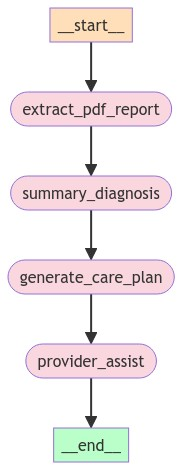

In [3]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))